In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
INPUT_DIR = "../input/"

train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")

In [3]:
pd.set_option('display.max_columns', 60)
train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878,-333.0,-522,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,365243,-4469.0,-3436,NaN,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523,-3640.0,-2050,NaN,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,3,0,Cash loans,F,N,Y,0,67500.0,152820.0,8901.0,135000.0,Children,Pensioner,Lower secondary,Widow,House / apartment,0.005002,-24177,365243,-4950.0,-3951,NaN,1,0,0,1,1,0,NaN,1.0,3,3,0,0,0,0,0,0,XNA,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,Cash loans,M,N,N,0,157500.0,271066.5,21546.0,234000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,0.006296,-10685,-697,-5101.0,-3226,NaN,1,1,1,1,0,0,Drivers,2.0,3,3,0,0,0,0,1,1,Business Entity Type 3,0.342344,0.202490,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0


In [4]:
test['TARGET'] = np.nan
data = pd.concat([train, test], ignore_index=True, sort=False)

In [5]:
# 融資額を月々の支払いで割った
data['NEW_CREDIT_TO_ANNUITY_RATIO'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['NEW_CREDIT_TO GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
data['NEW_INC_PER_CHILD'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])
data['NEW_EMPLOY_TO_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['NEW_ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / (1 + data['AMT_INCOME_TOTAL'])
data['NEW_SCORES_SUM'] = data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3']
data['NEW_EXT_SOURCES_PROD'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
data['NEW_SOURES_MEAN'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
data['NEW_SCORES_STD'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
data['NEW_SCORES_STD'] = data['NEW_SCORES_STD'].fillna(data['NEW_SCORES_STD'].mean())
data['NEW_CAR_TO_BIRTH_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
data['NEW_CAR_TO_EMPLOY_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
data['NEW_PHONE_TO_BIRTH_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']
data['NEW_PHONE_TO_EMPLOY_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_EMPLOYED']
data['NEW_CREDIT_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']


In [6]:
categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data, columns=categorical_columns, dummy_na=True)

In [7]:
data.head(5)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,...,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan
0,0,0.0,0,112500.0,755190.0,36328.5,675000.0,0.010032,-9233,-878,-333.0,-522,NaN,1,1,1,1,0,0,2.0,2,2,0,1,1,0,1,1,NaN,0.372591,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.0,0,225000.0,585000.0,16893.0,585000.0,0.008019,-20148,365243,-4469.0,-3436,NaN,1,0,0,1,0,0,2.0,2,2,0,0,0,0,0,0,NaN,0.449567,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,0.0,0,54000.0,334152.0,18256.5,270000.0,0.004960,-18496,-523,-3640.0,-2050,NaN,1,1,1,1,1,0,2.0,2,2,0,0,0,0,0,0,NaN,0.569503,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0.0,0,67500.0,152820.0,8901.0,135000.0,0.005002,-24177,365243,-4950.0,-3951,NaN,1,0,0,1,1,0,1.0,3,3,0,0,0,0,0,0,NaN,0.105235,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,1.0,0,157500.0,271066.5,21546.0,234000.0,0.006296,-10685,-697,-5101.0,-3226,NaN,1,1,1,1,0,0,2.0,3,3,0,0,0,0,1,1,0.342344,0.202490,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
data['TARGET'].isnull().sum()

61500

In [9]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [10]:
train = data[data['TARGET'].notnull()]
test = data[data['TARGET'].isnull()]

lightgbmでの方法

https://www.kaggle.com/code/ogrellier/lighgbm-with-selected-features
https://www.kaggle.com/code/znyksh/fork-lightgbm-with-simple-features


In [11]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
oof = pd.DataFrame()
models = []
scores = 0.0
feats = [f for f in train.columns if f not in ['TARGET', 'SK_ID_CURR', 'index']]


for fold, (train_idx, valid_idx) in enumerate(skf.split(train[feats], train['TARGET'])):
  train_x, train_y = train[feats].iloc[train_idx], train['TARGET'].iloc[train_idx]
  valid_x, valid_y = train[feats].iloc[valid_idx], train['TARGET'].iloc[valid_idx]

  print("Fold : ", fold + 1)

  lgb = LGBMClassifier(n_estimators=10000, random_state=0, learning_rate=0.01, verbose=-1)
  lgb.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], early_stopping_rounds=100, verbose=100)

  lgb_train_pred = lgb.predict_proba(valid_x, num_iteration=lgb.best_iteration_)[:,1]
  score = roc_auc_score(valid_y, lgb_train_pred)
  print(f"validation ROC-AUC score : {score:.4f}")

  scores += score / 5
  models.append(lgb)
  print("*" * 20) 

print(f"All fold average score : {scores:.4f}")

Fold :  1
[100]	training's binary_logloss: 0.25482	valid_1's binary_logloss: 0.257466
[200]	training's binary_logloss: 0.247	valid_1's binary_logloss: 0.251966
[300]	training's binary_logloss: 0.242258	valid_1's binary_logloss: 0.249774
[400]	training's binary_logloss: 0.238625	valid_1's binary_logloss: 0.248571
[500]	training's binary_logloss: 0.235637	valid_1's binary_logloss: 0.247983
[600]	training's binary_logloss: 0.233004	valid_1's binary_logloss: 0.247657
[700]	training's binary_logloss: 0.230631	valid_1's binary_logloss: 0.247547
[800]	training's binary_logloss: 0.22847	valid_1's binary_logloss: 0.24747
[900]	training's binary_logloss: 0.226402	valid_1's binary_logloss: 0.247379
[1000]	training's binary_logloss: 0.224442	valid_1's binary_logloss: 0.247344
[1100]	training's binary_logloss: 0.222556	valid_1's binary_logloss: 0.247325
[1200]	training's binary_logloss: 0.220727	valid_1's binary_logloss: 0.247283
[1300]	training's binary_logloss: 0.218947	valid_1's binary_logloss: 

In [12]:
preds = np.zeros(len(test))
test = test[feats]

for model in models:
  pred = model.predict_proba(test)[:, 1]
  preds += pred / len(models)

sample_sub['TARGET'] = preds
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.034344
1,171203,0.205441
2,171204,0.160406
3,171205,0.115669
4,171206,0.222177
...,...,...
61495,232697,0.120908
61496,232698,0.036978
61497,232699,0.041260
61498,232700,0.155440


In [20]:
importance = pd.DataFrame(models[0].feature_importances_, index=test.columns, columns=['importance'])
importance.sort_values('importance', ascending=False).head(10)

,importance
NEW_CREDIT_TO_ANNUITY_RATIO,3278
EXT_SOURCE_3,2140
DAYS_BIRTH,2001
NEW_SOURES_MEAN,1759
DAYS_ID_PUBLISH,1695
EXT_SOURCE_2,1617
DAYS_REGISTRATION,1598
NEW_CREDIT_TOGOODS_RATIO,1467
AMT_ANNUITY,1418
REGION_POPULATION_RELATIVE,1247


In [21]:
print(train.columns[train.isnull().sum() > 0])

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NEW_CREDIT_TO_ANNUITY_RATIO',
       'NEW_CREDIT_TOGOODS_RATIO', 'NEW_ANNUITY_TO_INCOME_RATIO',
       'NEW_SCORES_SUM', 'NEW_EXT_SOURCES_PROD', 'NEW_SOURES_MEAN',
       'NEW_CAR_TO_BIRTH_RATIO', 'NEW_CAR_TO_EMPLOY_RATIO',
       'NEW_PHONE_TO_BIRTH_RATIO', 'NEW_PHONE_TO_EMPLOY_RATIO',
       'NEW_CREDIT_TO_INCOME_RATIO'],
      dtype='object')


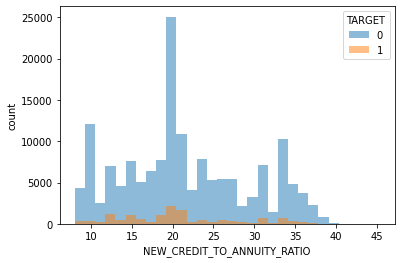

In [27]:
credit_0 = train.loc[train['TARGET'] == 0, 'NEW_CREDIT_TO_ANNUITY_RATIO'].dropna()
credit_1 = train.loc[train['TARGET'] == 1, 'NEW_CREDIT_TO_ANNUITY_RATIO'].dropna()
plt.hist(credit_0, bins=30, alpha=0.5, label='0')
plt.hist(credit_1, bins=30, alpha=0.5, label='1')
plt.xlabel('NEW_CREDIT_TO_ANNUITY_RATIO')
plt.ylabel('count')
plt.legend(title='TARGET')

In [30]:
print(train.shape)
print(test.shape)

(171202, 182)
(61500, 180)


In [35]:
print(train['NEW_CREDIT_TO_ANNUITY_RATIO'].isnull().sum())
print(test['NEW_CREDIT_TO_ANNUITY_RATIO'].isnull().sum())

6
3


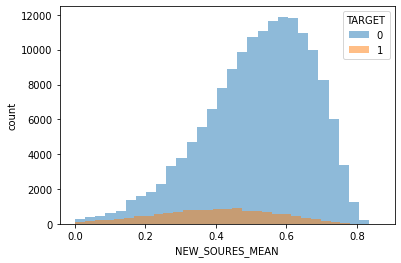

In [37]:
credit_0 = train.loc[train['TARGET'] == 0, 'NEW_SOURES_MEAN'].dropna()
credit_1 = train.loc[train['TARGET'] == 1, 'NEW_SOURES_MEAN'].dropna()
plt.hist(credit_0, bins=30, alpha=0.5, label='0')
plt.hist(credit_1, bins=30, alpha=0.5, label='1')
plt.xlabel('NEW_SOURES_MEAN')
plt.ylabel('count')
plt.legend(title='TARGET')

In [36]:
print(train['NEW_SOURES_MEAN'].isnull().sum())
print(test['NEW_SOURES_MEAN'].isnull().sum())

117
43


In [ ]:
print(train['EXT_SOURCE_2'].isnull().sum())
print(test['EXT_SOURCE_2'].isnull().sum())

In [39]:
print(train['NEW_CREDIT_TOGOODS_RATIO'].isnull().sum())
print(test['NEW_CREDIT_TOGOODS_RATIO'].isnull().sum())

163
53


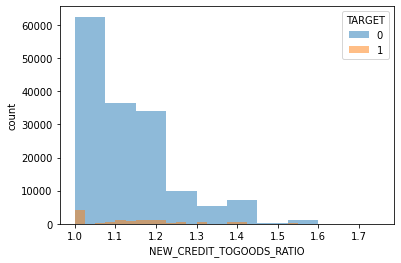

In [45]:
credit_0 = train.loc[train['TARGET'] == 0, 'NEW_CREDIT_TOGOODS_RATIO'].dropna()
credit_1 = train.loc[train['TARGET'] == 1, 'NEW_CREDIT_TOGOODS_RATIO'].dropna()
plt.hist(credit_0, bins=10, alpha=0.5, label='0', range=(1, 1.75))
plt.hist(credit_1, bins=30, alpha=0.5, label='1', range=(1, 1.75))
plt.xlabel('NEW_CREDIT_TOGOODS_RATIO')
plt.ylabel('count')
plt.legend(title='TARGET')

In [46]:
print(train['AMT_ANNUITY'].isnull().sum())
print(test['AMT_ANNUITY'].isnull().sum())

6
3


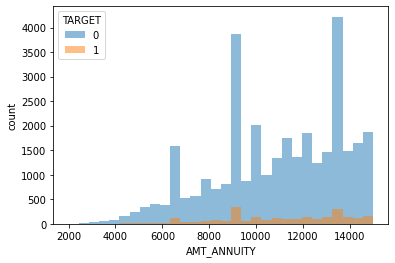

In [49]:
credit_0 = train.loc[train['TARGET'] == 0, 'AMT_ANNUITY'].dropna()
credit_1 = train.loc[train['TARGET'] == 1, 'AMT_ANNUITY'].dropna()
plt.hist(credit_0, bins=30, alpha=0.5, label='0', range=(2000, 15000))
plt.hist(credit_1, bins=30, alpha=0.5, label='1', range=(2000, 15000))
plt.xlabel('AMT_ANNUITY')
plt.ylabel('count')
plt.legend(title='TARGET')

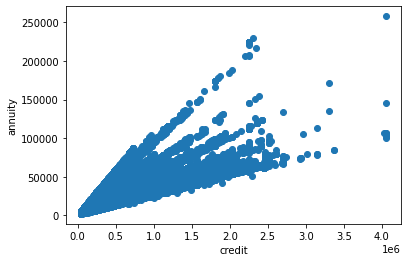

In [61]:
annuity = train.loc[data['AMT_ANNUITY'].isnull() == False, 'AMT_ANNUITY'].dropna()
credit = train.loc[data['AMT_ANNUITY'].isnull() == False, 'AMT_CREDIT'].dropna()
plt.xlabel('credit')
plt.ylabel('annuity')
plt.scatter(credit, annuity)

In [ ]:
あいう

In [ ]:
sample_sub.to_csv('../submission/submission3.csv',index=False)